In [16]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
import pickle
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import PointProcess
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from linkfunctions import Exp
from models import PointProcessGPSDEmodel, GPSDE

In [17]:
print(torch.__version__) # double check that this is the version from requirements.txt

1.10.1


### Data

In [18]:
def plotRaster(event_times_list, **kwargs):
    """ function to plot raster plot for a given trial"""
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

In [19]:
data = np.load('../Data/Cellline1_Date190328_Chip2135.npz', allow_pickle=True)

In [20]:
yDim = 40 #nmb neurons
nTrials = 3
tmax = 40
trLen = tmax * np.ones(nTrials)
times, ids = data['times'], data['ids']
ids_set, counts = np.unique(ids, return_counts=True)
valid_ids_set = ids_set[np.argsort(counts)[::-1][:yDim]] #choice of neurons

times = times[np.isin(ids, valid_ids_set)]
ids = ids[np.isin(ids, valid_ids_set)]

Yspike = []

for i in range(nTrials): #every trial is 30s in the time serie (a bit of explanation on this )
    Ytrial = []
    valid_spk_idx = np.logical_and(times > i*tmax, times < (i+1)*tmax)
    valid_times = times[valid_spk_idx] - i*tmax
    valid_ids = ids[valid_spk_idx]
    for neuron_id in valid_ids_set:
        Ytrial.append(valid_times[valid_ids == neuron_id])
    Yspike.append(Ytrial)

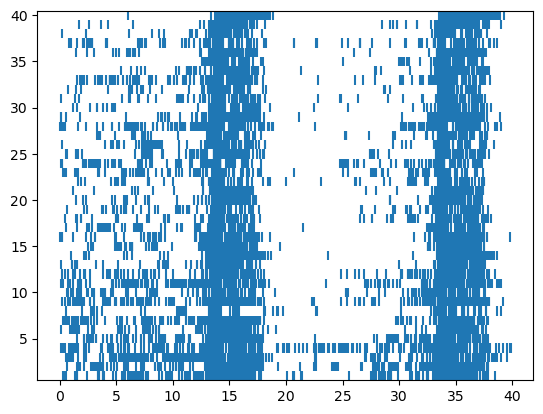

In [21]:
nps=23
ts=22
np.random.seed(nps)
torch.manual_seed(ts) #mu ini

xDim = 2
trLen = tmax * np.ones(nTrials) # trial length
C = 2.*np.random.rand(xDim,yDim) * np.random.choice([-1,1],size=(xDim,yDim))
d = 0.1*np.random.randn(1,yDim)

plotRaster(Yspike[1])
plt.show()

### Model

In [22]:
dtgrid = 0.01 # discretisation for solving ODEs
xDim = 2 # two latents

# pick model components:
link = Exp() # exponential link function
like = PointProcess(Yspike, link, trLen, dtstep=dtgrid, nLeg=100) # point process likelihood
outputMapping = AffineMapping(torch.tensor(C), torch.tensor(d)) # affine output mapping
kern = RBF(xDim, lengthscales_Init=5 * torch.ones((xDim, 1))) # RBF kernel, length scale = 10% (xmax-xmin)^2
#kern.lengthscales.requires_grad = False # fix kernel lengthscales

# generater inducing point locations on a 2D grid
xmin, xmax = -20., 20.
numZ = 5
Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,numZ), torch.linspace(xmin,xmax,numZ)])

Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)

transfunc = SparseGP(kern, Zs, useClosedForm=False) # choose sparse GP as a transition function
transfunc.q_mu.data = torch.randn(transfunc.q_mu.size()).type(torch.float64) # random initialisation for inducing point posterior mean

# uncomment to instead condition on fixed points
#Zs_fx = torch.tensor([0., 0.]).view(-1,xDim)
# transition function conditioned on fixed point
#transfunc = SparseGP(kern, Zs, Zs_fx) 


# build point procces generative model for continuous time spike-time observations
model = PointProcessGPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# assemble inference algorithm
lr=0.1 #learning rate
inference = GaussMarkovLagrange(xDim, trLen, learningRate=lr, dtstep=dtgrid)

# create GPSDE model object 
myGPSDE = GPSDE(model, inference)

# fix inducing points on chosen grid
myGPSDE.model.transfunc.Zs.requires_grad = False


### Run and save

In [23]:
name='N'+str(yDim)+'_t'+str(tmax)+'_Tr'+str(nTrials)+'_s'+str(nps)+str(ts)+'_x'+str(xmax)+'_lscale5'

In [24]:
# run EM (increase number of iterations for better results)
myGPSDE.variationalEM(niter=130,eStepIter=2, mStepIter=2)
#myGPSDE.variationalEM(niter=30,eStepIter=1, mStepIter=2)

-------------------------------------------------------
iter   objective    log-like      kl-div     f-prior
-------------------------------------------------------
   0   10215.870   -4569.996    5522.702    -123.172
   1    8983.449   -3856.716    5006.503    -120.230
   2    7777.887   -3115.252    4544.703    -117.932
   3    6592.044   -2344.985    4131.003    -116.055
   4    5415.948   -1541.503    3759.964    -114.481
   5    4238.280    -697.663    3427.481    -113.137
   6    3045.650     196.365    3130.041    -111.974
   7    1822.569    1152.961    2864.568    -110.963
   8     552.185    2186.247    2628.356    -110.077
   9    -781.288    3309.615    2419.028    -109.300
  10   -2186.861    4529.931    2234.455    -108.614
  11   -3656.290    5836.917    2072.620    -108.007
  12   -5152.267    7191.162    1931.432    -107.463
  13   -6611.654    8527.360    1808.738    -106.968
  14   -7977.995    9787.161    1702.656    -106.510
  15   -9229.875   10947.677    1611.723

In [25]:
#Save the results
torch.save(myGPSDE.model,'Graph_and_modelsave/GPSDE_model_'+name+'.pt')
with open("Graph_and_modelsave/GPSDE_inference_"+name+".pkl",'wb') as file:
    pickle.dump(myGPSDE.inference,file)

with open("Graph_and_modelsave/GPSDE_"+name+".pkl",'wb') as file:
    pickle.dump(myGPSDE,file)

### Load

In [26]:
model=torch.load('Graph_and_modelsave/GPSDE_model_'+name+'.pt')
with open("Graph_and_modelsave/GPSDE_inference_"+name+".pkl",'rb') as file:
    inference=pickle.load(file)

### Plots

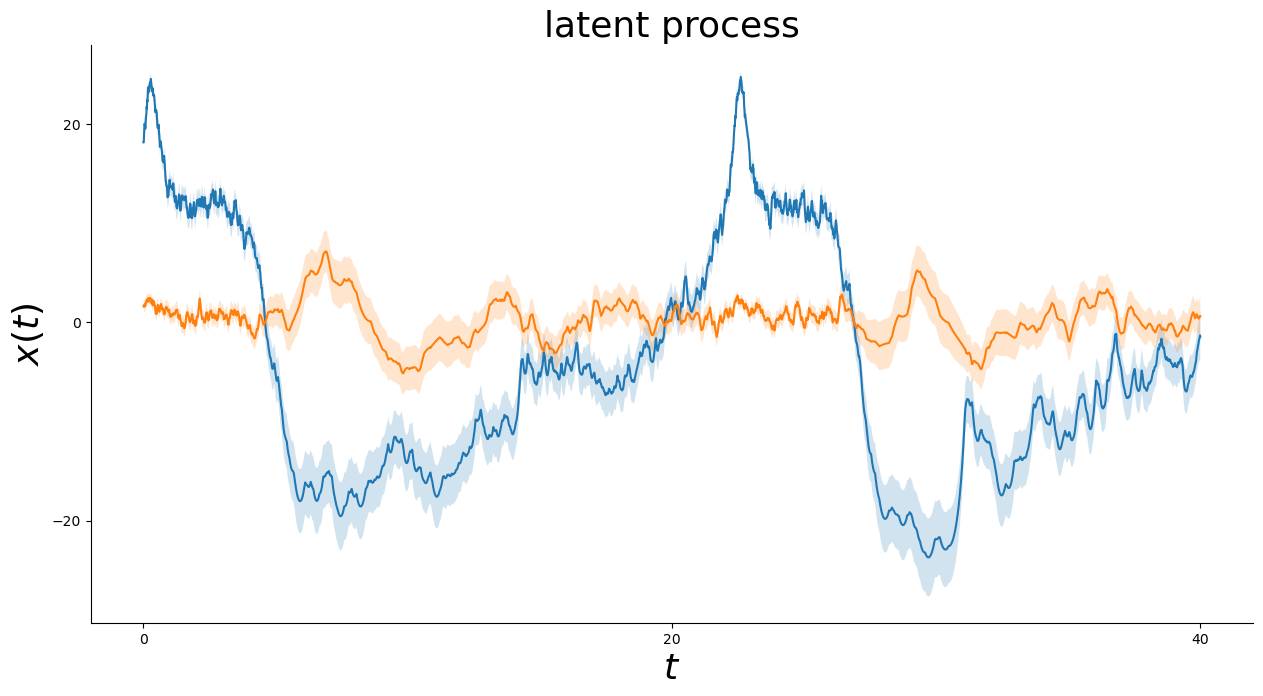

In [27]:
# evaluate trial
idx = 0
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001))

m, S = myGPSDE.inference.predict_marginals(idx, testTimes)
mr, Sr, Corth = myGPSDE.model.outputMapping.orthogonaliseLatents(m,S)


# plot the latent path and data in orthogonalised subspace
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(15)
for i in range(xDim):
#     ax.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.5,label='x(t)')
    ax.plot(testTimes.numpy(),mr[:,0,i].detach().squeeze().numpy(), label='$m_x(t)$')
    ax.fill_between(testTimes.numpy(), mr[:,0,i].detach().numpy()+np.sqrt(Sr[:,i,i].detach().numpy()), 
                mr[:,0,i].detach().squeeze().numpy()-np.sqrt(Sr[:,i,i].detach().numpy()), alpha=0.2)

    
#Latents = Corth.detach().numpy().T @ (np.stack(logRate[idx] - d).T) # data projected into same subspace as inferred latents
#plt.plot(np.linspace(0,trLen[idx],int(trLen[idx]/0.001)),Latents[0,:],color='black')
#plt.plot(np.linspace(0,trLen[idx],int(trLen[idx]/0.001)),Latents[1,:],color='black')

# plot where observatioins lie
ax.locator_params(nbins=4)
ax.set_ylabel('$x(t)$',fontsize=26)
ax.set_xlabel('$t$',fontsize=26)
ax.set_title('latent process',fontsize=26)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('Graph_and_modelsave/Latent_graph_'+name+'.pdf')
plt.show()

In [28]:
# visualise learned transition function and true transition function
ngrid = 200
xmin = -21
xmax = 21
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = myGPSDE.model.transfunc.predict(xygrid.unsqueeze(0))
#out_true = func(np.concatenate((yv.numpy().reshape(-1, 1),xv.numpy().reshape(-1, 1)),axis=1))


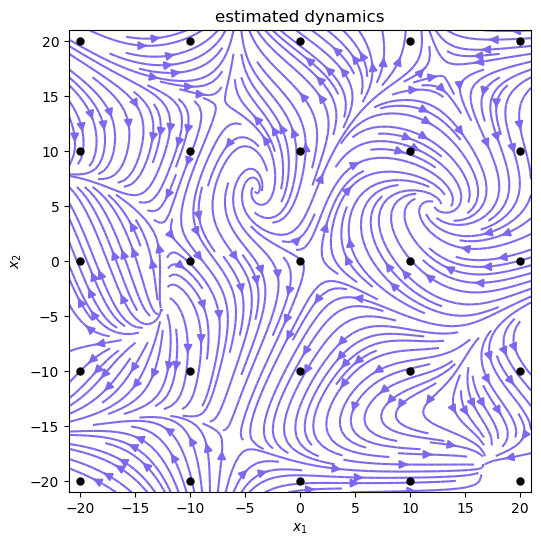

In [29]:

# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))

plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')
#plt.plot(mr[:,0,0].detach().squeeze().numpy(), mr[:,0,1].detach().squeeze().numpy())

plt.plot(myGPSDE.model.transfunc.Zs.detach().numpy()[:,0,], myGPSDE.model.transfunc.Zs.detach().numpy()[:,1], 'o', color='black', markersize=5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics')
plt.axis('square')
#plt.locator_params(nbins=3)
plt.savefig('Graph_and_modelsave/dynamics_'+name+'.pdf')
plt.show()

In [30]:
myGPSDE.model.transfunc.Zs

Parameter containing:
tensor([[-20., -20.],
        [-20., -10.],
        [-20.,   0.],
        [-20.,  10.],
        [-20.,  20.],
        [-10., -20.],
        [-10., -10.],
        [-10.,   0.],
        [-10.,  10.],
        [-10.,  20.],
        [  0., -20.],
        [  0., -10.],
        [  0.,   0.],
        [  0.,  10.],
        [  0.,  20.],
        [ 10., -20.],
        [ 10., -10.],
        [ 10.,   0.],
        [ 10.,  10.],
        [ 10.,  20.],
        [ 20., -20.],
        [ 20., -10.],
        [ 20.,   0.],
        [ 20.,  10.],
        [ 20.,  20.]])